# audit-AI
In this notebook, I'll be diving into the capabilities of pymetrics-bias-testing-package as a tool to measure and mitigate the effects discriminatory patterns in training data and the predictions made by machine learning algorithms trained for the purposes of socially sensitive decision processes.

The overall goal of this research is to come up with a reasonable way to think about how to make machine learning algorithms more fair. While identifying potential bias in training datasets and by consequence the machine learning algorithms trained on them is not sufficient to solve the problem of discrimination, in a world where more and more decisions are being automated by Artifical Intelligence, our ability to understand and identify the degree to which an algorithm is fair or biased is a step in the right direction.

In this notebook, I'll be using the <a href="https://archive.ics.uci.edu/ml/datasets/student+performance">Student Performance Data Set</a> from the UCI Machine Learning Repository, which consists of 385 students with 33 input variables (including sex, age, and health status) and 1 continuous target variable G3, which is the overall score that ranges from 0-20.

In the context of a machine learning model to predict grades , our objectives are to:

1. Measure the degree of bias in the training data with respect to some bias metric and protected class(age, gender, and previous performance).
2. Train a model on the training data, make predictions on a testing set, and show that an
algorithm trained on a biased training set lead to a biased algorithm.
3. Measure the effects of using a biased machine learning model.

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (GridSearchCV,
                                     learning_curve,
                                     ShuffleSplit,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             mean_absolute_error,
                             precision_score,
                             recall_score)

from auditai.misc import bias_test_check
from auditai.viz import (plot_group_proportions,
                             plot_kdes,
                             plot_threshold_tests)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Import Data

In [2]:
data = pd.read_csv('../data/student-mat.csv', delimiter=';')

In [3]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
# Take the final grade and converting that into a percentage
data['Grade'] = data['G3']/20*100

## Measure Bias in Training data

### Protected Class: Sex

In [5]:
# Preliminary stats
breakdown_by_gender = pd.value_counts(data['sex'].values, sort=False)
breakdown_by_gender

F    208
M    187
dtype: int64

In [6]:
female_students = data[data['sex'] == 'F']
male_students = data[data['sex'] == 'M']

print ('Mean grade% of female students = ', np.mean(female_students['Grade']))
print ('Median grade% of female students = ', np.median(female_students['Grade']))
print ('Mean grade% of male students = ', np.mean(male_students['Grade']))
print ('Median grade% of male students = ', np.median(male_students['Grade']))

Mean grade% of female students =  49.83173076923077
Median grade% of female students =  50.0
Mean grade% of male students =  54.57219251336898
Median grade% of male students =  55.00000000000001


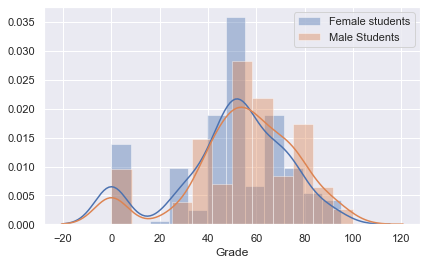

In [7]:
sns.set()

sns.distplot(female_students['Grade'], label='Female students')
sns.distplot(male_students['Grade'], label='Male Students')
plt.legend()
plt.show()

#### As we can see the mean and median scores for male students is higher than that of female students. Also the distribution of grades for male and female students show that in the training data, male students perform slightly better than female students. There is a possibility that a machine learning algorithm trained on this data will assume for all other features being the same, that a male student will score more than a female student.

### Protected Class: Previous Academic performance

In [8]:
data['failures'].value_counts()

0    312
1     50
2     17
3     16
Name: failures, dtype: int64

In [9]:
# Preliminary stats
data['failed_before'] = data['failures'] != 0
breakdown_by_failed_before = pd.value_counts(data['failed_before'].values, sort=False)
breakdown_by_failed_before

False    312
True      83
dtype: int64

In [10]:
failed_before = data[data['failed_before'] == True]
never_failed_before = data[data['failed_before'] == False]

print('Mean grade% of students who have failed before = ', np.mean(failed_before['Grade']))
print('Median grade% of students who have failed before = ', np.mean(failed_before['Grade']))
print('Mean grade% of students who have never failed before = ', np.mean(never_failed_before['Grade']))
print('Median grade% of students who have never failed before = ', np.median(never_failed_before['Grade']))


Mean grade% of students who have failed before =  36.325301204819276
Median grade% of students who have failed before =  36.325301204819276
Mean grade% of students who have never failed before =  56.26602564102564
Median grade% of students who have never failed before =  55.00000000000001


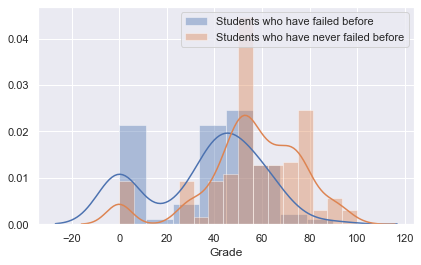

In [11]:
sns.set()

sns.distplot(failed_before['Grade'], label='Students who have failed before')
sns.distplot(never_failed_before['Grade'], label='Students who have never failed before')
plt.legend()
plt.show()

#### As we can see the mean and median scores for students who have never failed before is significantly higher than those who have failed before. While history is sometimes a good predictore of the future, a machine learning model trained on this dataset will be very harsh in terms of penalizing students who have failed before.

## Preprocessing and feature engineering

In [12]:
# One hot encoding categorical features
nominal_features = ['Mjob',          
'Fjob',          
'reason',        
'guardian']    

# One hot encoding for all nominal features

data = pd.get_dummies(data, columns = nominal_features)

# Label encoding binary features
binary_features = [
'school',
'sex',
'address',
'famsize',
'Pstatus',
'schoolsup',
'famsup',
'paid',
'activities',
'nursery',
'higher',
'internet',
'romantic'
]

# Label Encoding for binary features

le = LabelEncoder()

for f in binary_features:
    if f =='sex':
        data['sex_lenc'] = le.fit_transform(data[f])
    else:
        data[f] = le.fit_transform(data[f])
   

In [13]:
features = ['school', 'sex_lenc', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'failed_before', 
       'Mjob_at_home', 'Mjob_health' , 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other']

In [14]:
X = data[features]
y = data['Grade']

# Creating training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [15]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The root mean squared error
print("Mean Absolute Error: %.2f %%"
      % (mean_absolute_error(y_test, y_pred)))


Mean Absolute Error: 16.18 %


## Testing models for bias against protected classes

#### Protected class: Sex

In [16]:
X_test['sex'] = X_test['sex_lenc'].apply(lambda x: 'Male' if x == 1 else 'Female')

In [17]:
bias_test_check(X_test['sex_lenc'], y_pred, category='Gender')

*Gender fails 4/5 test at 54.18*
 - Gender minimum proportion at 54.18: 0.487
*Gender fails Fisher exact test at 54.18*
  - Gender p-value at 54.18: 0.000
*Gender fails Chi squared test at 54.18*
  - Gender p-value at 54.18: 0.000
*Gender fails z test at 54.18*
  - Gender Z-test p-value at 54.18: 0.000
*Gender Bayes Factor test at 54.18*
  - Gender Bayes Factor at 54.18: 398.803


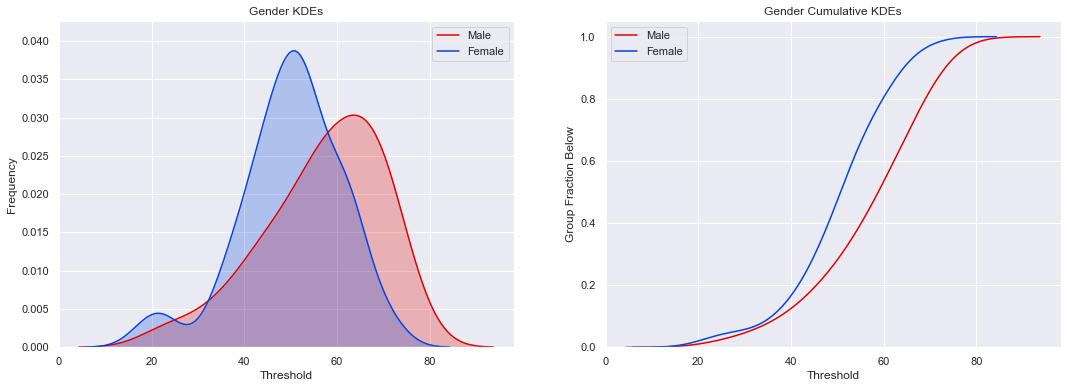

In [18]:
a = plot_kdes(labels=X_test['sex'],results=y_pred, category='Gender')

#### Protected class: Previous performance

In [19]:
bias_test_check(X_test['failed_before'], y_pred, category='Previous performance')

*Previous performance fails 4/5 test at 54.18*
 - Previous performance minimum proportion at 54.18: 0.075
*Previous performance fails Fisher exact test at 54.18*
  - Previous performance p-value at 54.18: 0.000
*Previous performance fails Chi squared test at 54.18*
  - Previous performance p-value at 54.18: 0.000
*Previous performance fails z test at 54.18*
  - Previous performance Z-test p-value at 54.18: 0.000
*Previous performance Bayes Factor test at 54.18*
  - Previous performance Bayes Factor at 54.18: 80757.051


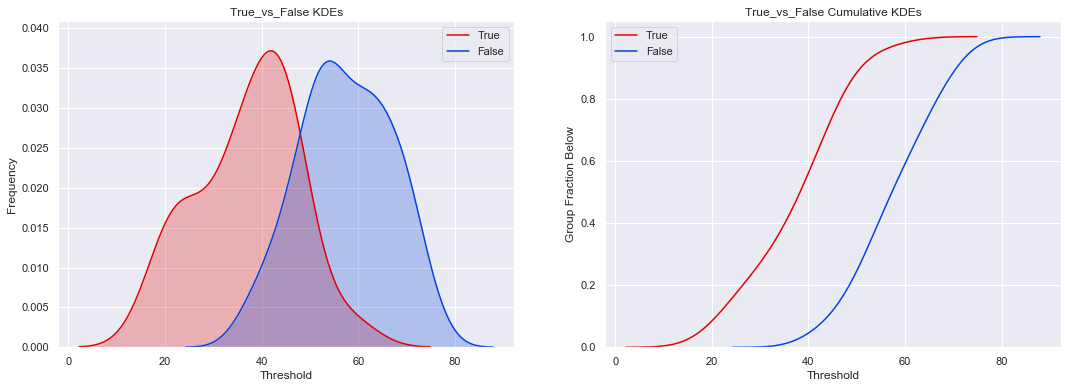

In [20]:
b = plot_kdes(labels=X_test['failed_before'],results=y_pred)

## Results and Conclusions

As we can see here, a machine learning model built on this training dataset will be negatively biased against female students and students who have failed in the past. Hopefully this simple example should illustrate how this package can be used to uncover the bias picked up by machine learning models when trained on biased datasets.